In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'inspection_persons', 'inspection_status_summary', 'lastUpdate', 'main_summary'])

In [5]:
# データフレームにセット
df = pd.DataFrame(j_res)

In [6]:
# `patients_summary`
df.patients_summary.data[-10:]

[{'日付': '2020-07-11T08:00:00.000Z', '小計': 206},
 {'日付': '2020-07-12T08:00:00.000Z', '小計': 206},
 {'日付': '2020-07-13T08:00:00.000Z', '小計': 119},
 {'日付': '2020-07-14T08:00:00.000Z', '小計': 143},
 {'日付': '2020-07-15T08:00:00.000Z', '小計': 165},
 {'日付': '2020-07-16T08:00:00.000Z', '小計': 286},
 {'日付': '2020-07-17T08:00:00.000Z', '小計': 293},
 {'日付': '2020-07-18T08:00:00.000Z', '小計': 290},
 {'日付': '2020-07-19T08:00:00.000Z', '小計': 188},
 {'日付': '2020-07-20T08:00:00.000Z', '小計': 168}]

In [7]:
# `patients_summary` の `data` を抽出しデータフレームにセット
sub_df = pd.DataFrame(df.patients_summary.data)
sub_df.tail()

,日付,小計
174,2020-07-16T08:00:00.000Z,286
175,2020-07-17T08:00:00.000Z,293
176,2020-07-18T08:00:00.000Z,290
177,2020-07-19T08:00:00.000Z,188
178,2020-07-20T08:00:00.000Z,168


In [8]:
# 日付型の列を追加
sub_df['datetime.date'] = [datetime.datetime.fromisoformat(str.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo')) for str in sub_df['日付']]
sub_df.tail()

,日付,小計,datetime.date
174,2020-07-16T08:00:00.000Z,286,2020-07-16 17:00:00+09:00
175,2020-07-17T08:00:00.000Z,293,2020-07-17 17:00:00+09:00
176,2020-07-18T08:00:00.000Z,290,2020-07-18 17:00:00+09:00
177,2020-07-19T08:00:00.000Z,188,2020-07-19 17:00:00+09:00
178,2020-07-20T08:00:00.000Z,168,2020-07-20 17:00:00+09:00


In [9]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
sub_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in sub_df['datetime.date']]
sub_df.tail()

,日付,小計,datetime.date,week_num
174,2020-07-16T08:00:00.000Z,286,2020-07-16 17:00:00+09:00,'20w29
175,2020-07-17T08:00:00.000Z,293,2020-07-17 17:00:00+09:00,'20w29
176,2020-07-18T08:00:00.000Z,290,2020-07-18 17:00:00+09:00,'20w29
177,2020-07-19T08:00:00.000Z,188,2020-07-19 17:00:00+09:00,'20w29
178,2020-07-20T08:00:00.000Z,168,2020-07-20 17:00:00+09:00,'20w30


In [10]:
# 週毎に集計
groupby_week_num = sub_df.groupby('week_num')
groupby_week_num

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': sub_df['week_num'].unique(),
    'mean': [m for m in groupby_week_num.agg({'小計': 'mean'})['小計']], 
    'sum': [s for s in groupby_week_num.agg({'小計': 'sum'})['小計']]
})
week_num_df.tail()

,week_num,mean,sum
22,'20w26,47.714286,334
23,'20w27,93.142857,652
24,'20w28,166.000000,1162
25,'20w29,212.000000,1484
26,'20w30,168.000000,168


### グラフ出力

In [12]:
### 日毎の数
x = sub_df['datetime.date']
y = sub_df['小計']

In [13]:
### 週毎の数
x2 = week_num_df['week_num']
y2_1 = week_num_df['mean']
y2_2 = week_num_df['sum']

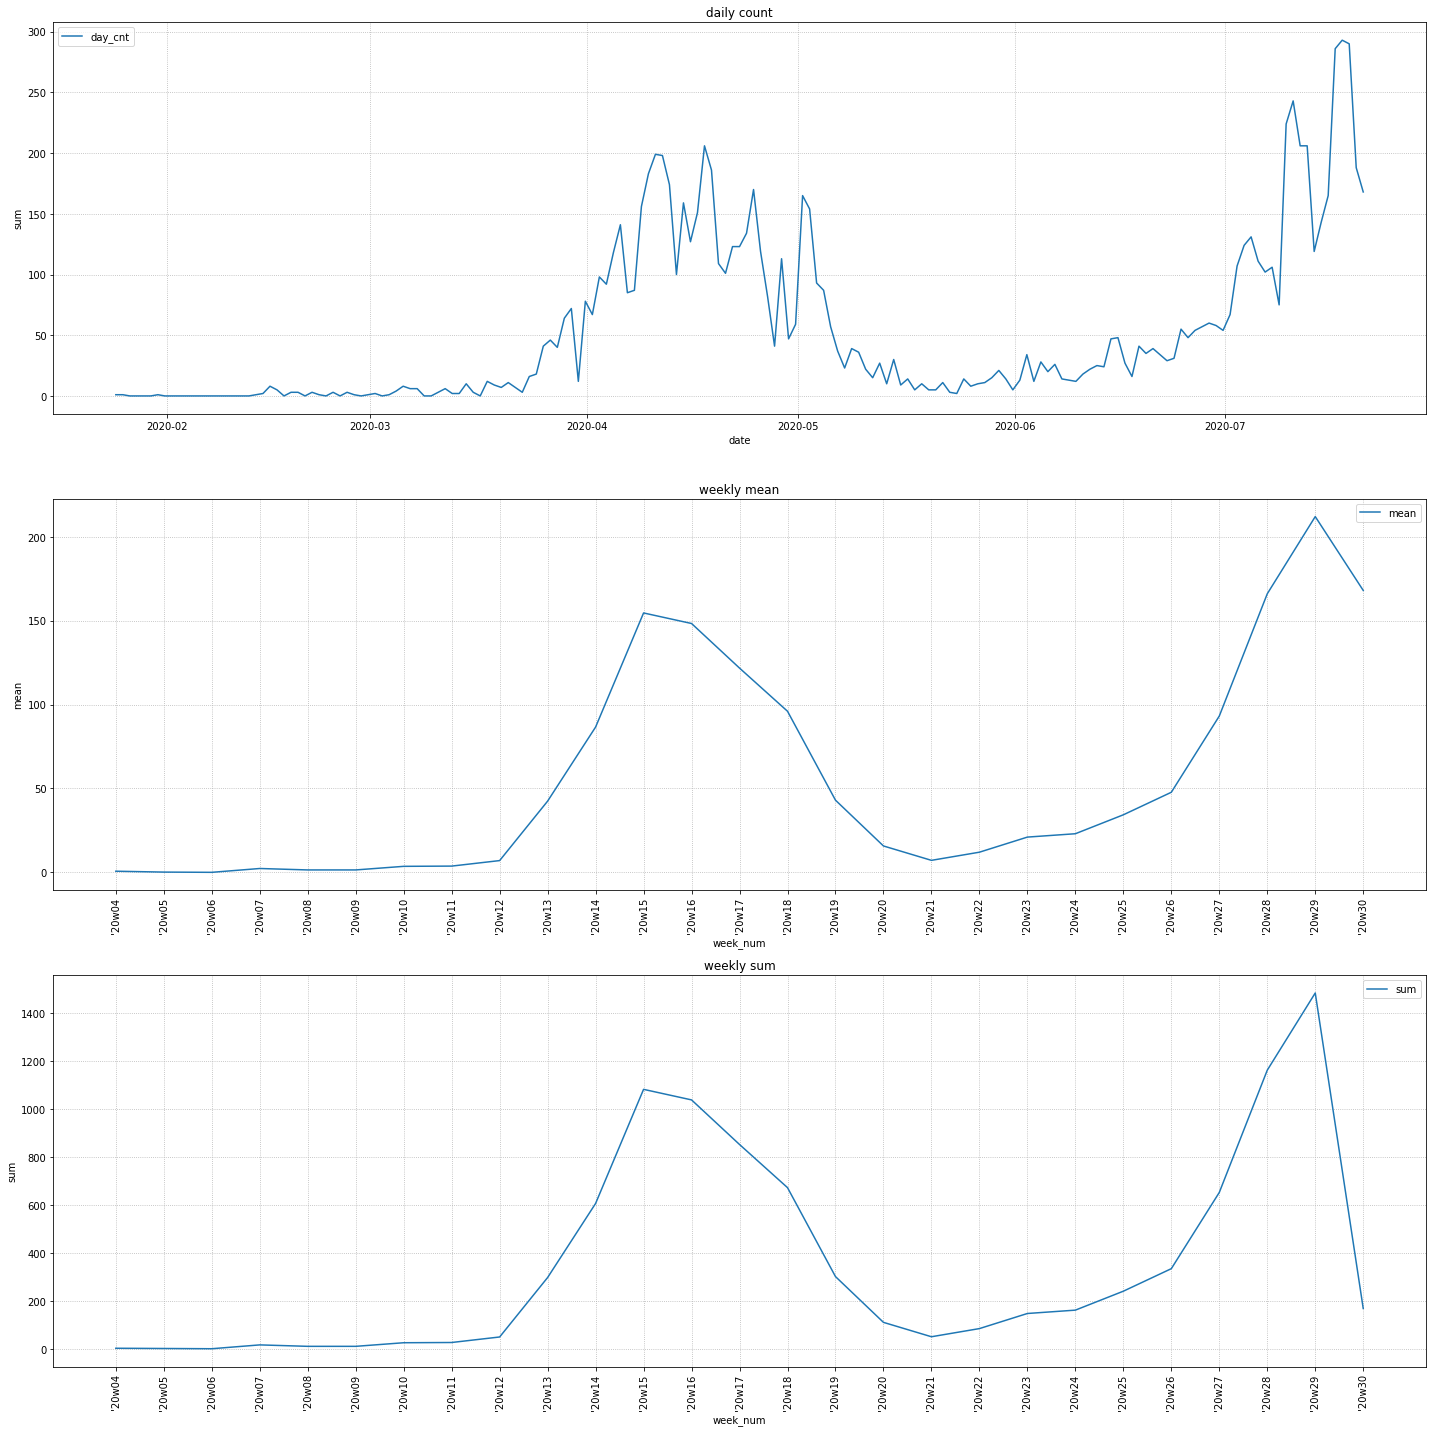

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y, label='day_cnt')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
ax[1].set_title('weekly mean')
ax[1].set_xticklabels(labels=x2, rotation=90)
ax[1].set_xlabel('week_num')
ax[1].set_ylabel('mean')
ax[1].plot(x2, y2_1, label='mean')
ax[1].grid(linestyle=':')
ax[1].legend()

### 週毎の合計
ax[2].set_title('weekly sum')
ax[2].set_xticklabels(labels=x2, rotation=90)
ax[2].set_xlabel('week_num')
ax[2].set_ylabel('sum')
ax[2].plot(x2, y2_2, label='sum')
ax[2].grid(linestyle=':')
ax[2].legend()

plt.tight_layout()